In [10]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
import torch
import torch.nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.utils import make_grid

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfms = T.Compose([
                  T.ToTensor(),
                  T.Normalize(mean=[0.5],
                              std=[0.5]),
                  T.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('/content/',train=True,transform=tfms,download=True)
val_ds = MNIST('/content/',train=False,transform=tfms,download=True)

trn_dl = DataLoader(trn_ds,batch_size=64,shuffle=True,drop_last=True)
val_dl = DataLoader(val_ds,batch_size=64,shuffle=False,drop_last=True)

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(784, 512)
        self.d2 = nn.Linear(512, 256)
        self.d31 = nn.Linear(256, 50)
        self.d32 = nn.Linear(256, 50)
        self.d4 = nn.Linear(50, 256)
        self.d5 = nn.Linear(256, 512)
        self.d6 = nn.Linear(512, 784)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var

In [13]:
def loss_fn(decode_x,x,mean,log_var):
  DECODE = F.mse_loss(decode_x,x.view(-1,784),reduction='sum')
  KL_Loss= -0.5*torch.sum(1+log_var-mean.pow(2)-log_var.exp())
  return DECODE+KL_Loss,DECODE,KL_Loss

In [14]:
def train_batch(img,model,optimizer,loss_fn):
  model.train()
  img = img.to(device)
  DECODE, mean, log_var = model(img)
  loss, mse, kld = loss_fn(DECODE,img,mean,log_var)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(img,model,loss_fn):
  model.eval()
  img = img.to(device)
  DECODE, mean, log_var = model(img)
  loss, mse, kld = loss_fn(DECODE,img,mean,log_var)
  return loss, mse, kld, log_var.mean(), mean.mean()

In [15]:
vae = VAE().to(device)
optimizer = torch.optim.AdamW(vae.parameters(),lr=1e-3)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1.000	trn_loss: 45522.008	trn_mse: 45134.805	trn_kld: 387.204	trn_log_var: -0.239	trn_mean: 0.000	val_loss: 45451.492	val_mse: 45070.781	val_kld: 380.709	val_log_var: -0.240	val_mean: 0.004	(16.81s - 151.25s remaining)


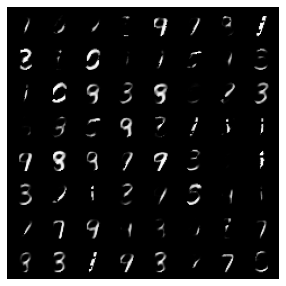

EPOCH: 2.000	trn_loss: 45482.281	trn_mse: 45079.309	trn_kld: 402.976	trn_log_var: -0.249	trn_mean: 0.000	val_loss: 45397.047	val_mse: 44988.027	val_kld: 409.022	val_log_var: -0.248	val_mean: 0.002	(33.68s - 134.72s remaining)


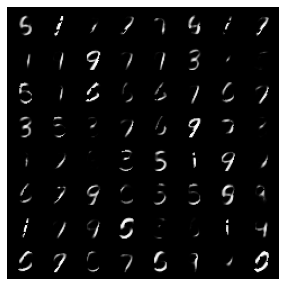

EPOCH: 3.000	trn_loss: 45442.707	trn_mse: 45023.621	trn_kld: 419.081	trn_log_var: -0.260	trn_mean: 0.000	val_loss: 45361.410	val_mse: 44924.816	val_kld: 436.592	val_log_var: -0.271	val_mean: -0.003	(50.61s - 118.10s remaining)


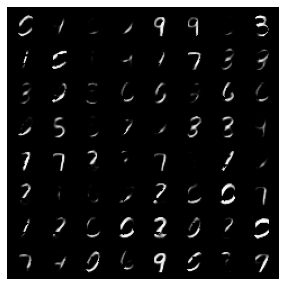

EPOCH: 4.000	trn_loss: 45399.934	trn_mse: 44963.945	trn_kld: 435.989	trn_log_var: -0.270	trn_mean: 0.000	val_loss: 45327.250	val_mse: 44880.031	val_kld: 447.218	val_log_var: -0.275	val_mean: -0.003	(67.95s - 101.93s remaining)


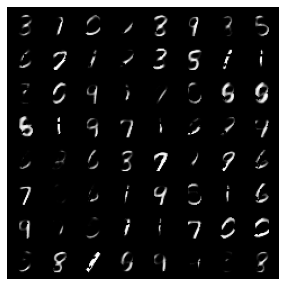

EPOCH: 5.000	trn_loss: 45355.199	trn_mse: 44903.086	trn_kld: 452.109	trn_log_var: -0.280	trn_mean: 0.000	val_loss: 45260.848	val_mse: 44814.504	val_kld: 446.350	val_log_var: -0.269	val_mean: -0.001	(84.99s - 84.99s remaining)


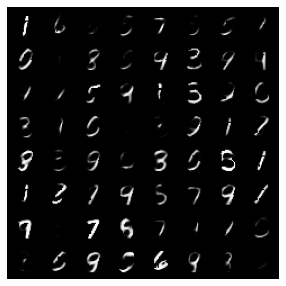

EPOCH: 6.000	trn_loss: 45288.562	trn_mse: 44813.594	trn_kld: 474.973	trn_log_var: -0.293	trn_mean: 0.000	val_loss: 45181.312	val_mse: 44694.555	val_kld: 486.763	val_log_var: -0.298	val_mean: 0.004	(102.47s - 68.32s remaining)


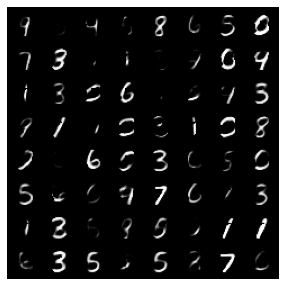

EPOCH: 7.000	trn_loss: 45201.613	trn_mse: 44702.438	trn_kld: 499.174	trn_log_var: -0.308	trn_mean: 0.000	val_loss: 45090.922	val_mse: 44589.117	val_kld: 501.801	val_log_var: -0.312	val_mean: 0.000	(120.19s - 51.51s remaining)


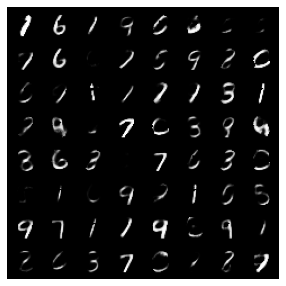

EPOCH: 8.000	trn_loss: 45135.297	trn_mse: 44619.457	trn_kld: 515.840	trn_log_var: -0.319	trn_mean: 0.000	val_loss: 45031.938	val_mse: 44486.398	val_kld: 545.539	val_log_var: -0.325	val_mean: 0.003	(137.40s - 34.35s remaining)


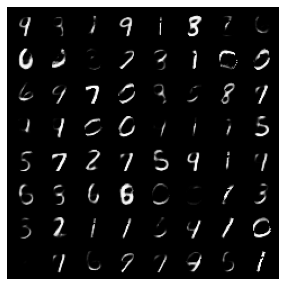

EPOCH: 9.000	trn_loss: 45083.680	trn_mse: 44556.074	trn_kld: 527.601	trn_log_var: -0.327	trn_mean: -0.000	val_loss: 44986.883	val_mse: 44448.992	val_kld: 537.885	val_log_var: -0.333	val_mean: -0.004	(154.76s - 17.20s remaining)


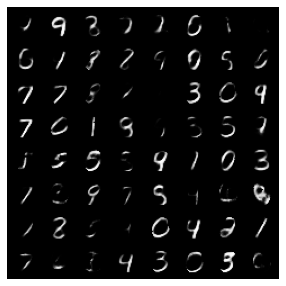

EPOCH: 10.000	trn_loss: 45041.098	trn_mse: 44503.574	trn_kld: 537.524	trn_log_var: -0.332	trn_mean: -0.000	val_loss: 44941.832	val_mse: 44388.562	val_kld: 553.272	val_log_var: -0.339	val_mean: -0.002	(171.99s - 0.00s remaining)


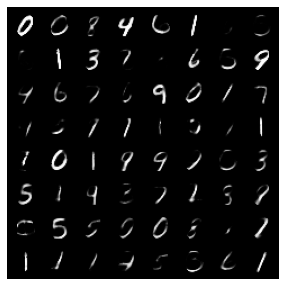

In [18]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
  N = len(trn_dl)
  for ix, (img, _) in enumerate(trn_dl):
    loss, mse, kld, log_var, mean = train_batch(img,vae,optimizer,loss_fn)
    log.record(epoch+(ix+1)/N,trn_loss=loss,trn_mse=mse,trn_kld=kld,trn_log_var=log_var,trn_mean=mean,end='\r')

  for ix, (img, _) in enumerate(val_dl):
    loss, mse, kld, log_var, mean = validate_batch(img,vae,loss_fn)
    log.record(epoch+(ix+1)/N,val_loss=loss,val_mse=mse,val_kld=kld,val_log_var=log_var,val_mean=mean,end='\r')
  log.report_avgs(epoch+1)

  with torch.no_grad():
    z =  torch.randn(64,50).to(device)
    sample =  vae.decoder(z).to(device)
    images = make_grid(sample.view(64,1,28,28)).permute(1,2,0)
    show(images)

100%|██████████| 111/111 [00:00<00:00, 332.42it/s]


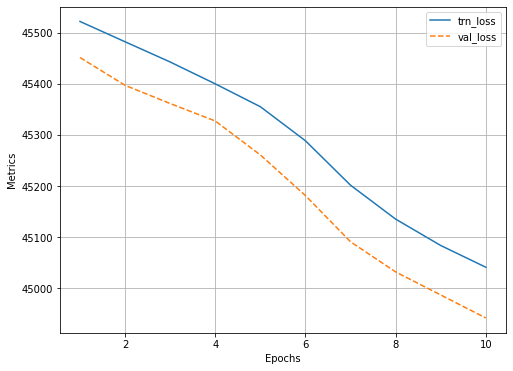

In [19]:
log.plot_epochs(['trn_loss','val_loss'])